# Introduction

1. **The goal**
- Forcast vac sales for December 2020, 31 days of the forecast horizon
- Insights

2. **The data**
- DecemberAdData
- MarketingSales 2016-01-01 - 2020-11-30 vac sales data

3. **The method**

Using Prophet and random forest as ensemble models to predict vac sales

- Prophet time series to forecast potential sales
- Random forest regressor to predict factors affecting sales
    - **Target**: `residual` = `actual_sales` - `prophet_sales_pred` 
    - **Features**: `Covid`, `positive news`, `negative coverage`, `competition`, `0508 line`, `ultra edition`
- SHAP values for model interpretation
- `Ensemble_sales_pred` = `prophet_sales_pred`+`residual`

4. **The metrics**

RMSE

5. **Alternative methods**

These methods are what I have tested for the past few days (Marked as optional)
- XGBoosst multistep forecasting (for vac sales predict)
    - pro
        - potential to have better performance on catching patterns
    - con
        - cannot extrapolate, not able to catch the trend
        - Train a separate model for each step on the horizon. But training lots of models can be computationally expensive.
        - Need spend more time on time-related features creating, used lag features only in experiment
        - Model is overfitting, need more time on parameter tuning


- ElasticNet (for residual prediction)
    - pro
        - easy to interpret, e.g. 1 unit increasing in advertising could lead to x unit increasing in vac sales
    - con
        - a slightly worse performance than the random forest model, and it was hugely impacted by the COVID feature, advertising didn't contribute too much
        
Other models could be SARIMA, and neural networks. Limited to the time I'm not able to do further research on these.

---

**Running the Notebook**

Before running the notebook, install the **requirements.txt** in a virtual environment first. 

*Follow the instruction on the [website](https://facebook.github.io/prophet/docs/installation.html#python) to install Prophet.*

`pip install requirements.txt`

---

# Load library

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
import os
os.listdir('Data/')

['.DS_Store',
 'DecemberAdData.csv',
 'DecemberCols.csv',
 'MarketingCols.csv',
 'MarketingSales.csv']

# Exploratory analysis

## Read data

In [4]:
DecAd_col = pd.read_csv('Data/DecemberCols.csv',header=None)
DecemberAdData = pd.read_csv('Data/DecemberAdData.csv',names=DecAd_col[0].values.tolist())
DecemberAdData['Date'] = pd.to_datetime(DecemberAdData['Date'],format='%d/%m/%y')
DecemberAdData.head()

Date  AdvertisingSpend     Month        Day
0 2020-12-01          10568.28  December    Tuesday
1 2020-12-02           8218.31  December  Wednesday
2 2020-12-03           4907.38  December   Thursday
3 2020-12-04           8057.25  December     Friday
4 2020-12-05          21481.50  December   Saturday

In [5]:
MarS_col = pd.read_csv('Data/MarketingCols.csv',header=None)
MarketingSales = pd.read_csv('Data/MarketingSales.csv',names=MarS_col[0].values.tolist())
MarketingSales['Date'] = pd.to_datetime(MarketingSales['Date'],format='%d/%m/%y')
MarketingSales['year'] = MarketingSales['Date'].dt.year
MarketingSales['mon'] = MarketingSales['Date'].dt.month
MarketingSales['day'] = MarketingSales['Date'].dt.day
MarketingSales['week_of_day'] = MarketingSales['Date'].dt.weekday
MarketingSales['quarter'] = MarketingSales['Date'].dt.quarter
MarketingSales.head()

Date  PositiveNews  NegativeCoverage  Competition  AdvertisingSpend  \
0 2016-01-01             0                 0            0           4199.86   
1 2016-01-02             0                 0            0          14768.20   
2 2016-01-03             0                 0            0          11019.79   
3 2016-01-04             0                 0            0           3358.30   
4 2016-01-05             0                 0            0           5207.19   

     Month       Day  0508Line_247  UltraEdition_Available  COVID_Lockdown  \
0  January    Friday             1                       0               0   
1  January  Saturday             1                       0               0   
2  January    Sunday             1                       0               0   
3  January    Monday             1                       0               0   
4  January   Tuesday             1                       0               0   

   Sales  year  mon  day  week_of_day  quarter  
0     66  2016    1    1            4        1  
1     84  2016    1    2            5        1  
2     78  2016    1    3            6        1  
3     70  2016    1    4            0        1  
4     73  2016    1    5            1        1

### December advertising data

In [6]:
DecemberAdData.describe()

AdvertisingSpend
count         31.000000
mean        9925.820000
std         7418.019253
min          250.690000
25%         4283.585000
50%         8618.290000
75%        13619.480000
max        29203.620000

<AxesSubplot:xlabel='AdvertisingSpend', ylabel='Count'>

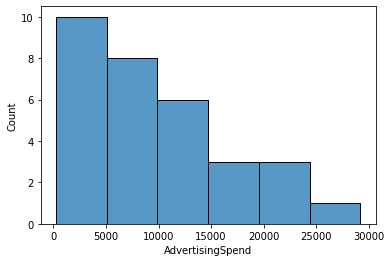

In [7]:
sns.histplot(DecemberAdData.AdvertisingSpend)

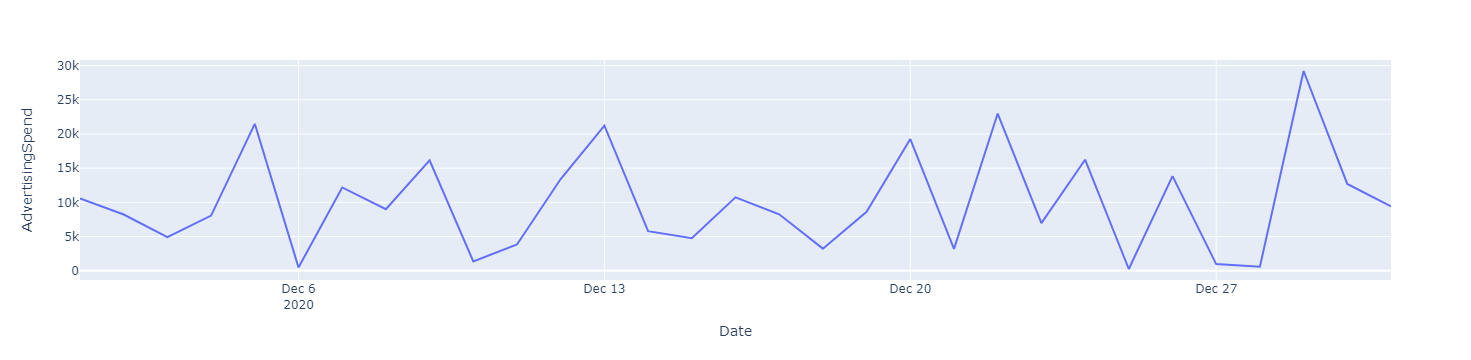

In [8]:
# sns.lineplot(data=DecemberAdData,x='Date',y='AdvertisingSpend')
# plt.xticks(rotation=45);

px.line(DecemberAdData,x='Date',y='AdvertisingSpend')

In [9]:
DecemberAdData[DecemberAdData.AdvertisingSpend>20000]

Date  AdvertisingSpend     Month       Day
4  2020-12-05          21481.50  December  Saturday
12 2020-12-13          21211.74  December    Sunday
21 2020-12-22          22980.20  December   Tuesday
28 2020-12-29          29203.62  December   Tuesday

Findings

- Every single day in 2020 Dec have advertising spends.
- Every 7-9 days, there's a boost in spending.


### Marketing vac sales data

In [10]:
MarketingSales['Date'].min()

Timestamp('2016-01-01 00:00:00')

In [11]:
MarketingSales['Date'].max()

Timestamp('2020-11-30 00:00:00')

In [12]:
MarketingSales.describe()

PositiveNews  NegativeCoverage  Competition  AdvertisingSpend  \
count   1796.000000       1796.000000  1796.000000       1796.000000   
mean       0.032294          0.008909     0.226615       7900.032372   
std        0.176829          0.093991     0.418758       6235.046578   
min        0.000000          0.000000     0.000000          0.000000   
25%        0.000000          0.000000     0.000000       2953.030000   
50%        0.000000          0.000000     0.000000       6583.465000   
75%        0.000000          0.000000     0.000000      11558.735000   
max        1.000000          1.000000     1.000000      46586.070000   

       0508Line_247  UltraEdition_Available  COVID_Lockdown        Sales  \
count   1796.000000             1796.000000     1796.000000  1796.000000   
mean       0.304566                0.492762        0.028953    78.702116   
std        0.460351                0.500087        0.167722    22.361472   
min        0.000000                0.000000        0.000000    11.000000   
25%        0.000000                0.000000        0.000000    64.000000   
50%        0.000000                0.000000        0.000000    77.000000   
75%        1.000000                1.000000        0.000000    92.000000   
max        1.000000                1.000000        1.000000   163.000000   

              year          mon          day  week_of_day      quarter  
count  1796.000000  1796.000000  1796.000000  1796.000000  1796.000000  
mean   2017.965479     6.426503    15.730512     3.001670     2.482183  
std       1.402715     3.403202     8.802303     2.001531     1.109701  
min    2016.000000     1.000000     1.000000     0.000000     1.000000  
25%    2017.000000     3.000000     8.000000     1.000000     1.000000  
50%    2018.000000     6.000000    16.000000     3.000000     2.000000  
75%    2019.000000     9.000000    23.000000     5.000000     3.000000  
max    2020.000000    12.000000    31.000000     6.000000     4.000000

## Visuals

Distribution of sales

Text(0.5, 1.0, 'distribution of historical vac sales')

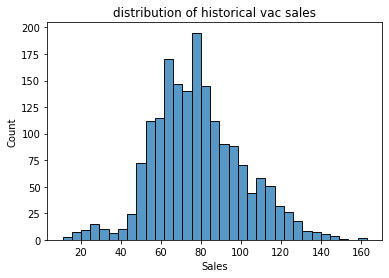

In [13]:
sns.histplot(MarketingSales.Sales)
plt.title('distribution of historical vac sales')

Distribution of advertising spends

Text(0.5, 1.0, 'distribution of historical advertising spends')

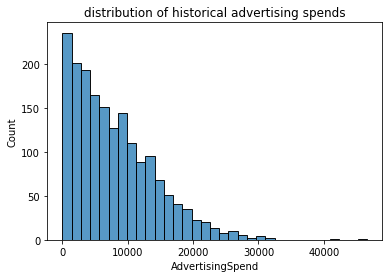

In [14]:
sns.histplot(MarketingSales.AdvertisingSpend)
plt.title('distribution of historical advertising spends')

**Findings**:

The distibution of advertising spends has a long tail and right skewed. Most of the advetise spends less than 10000

---

Correlation

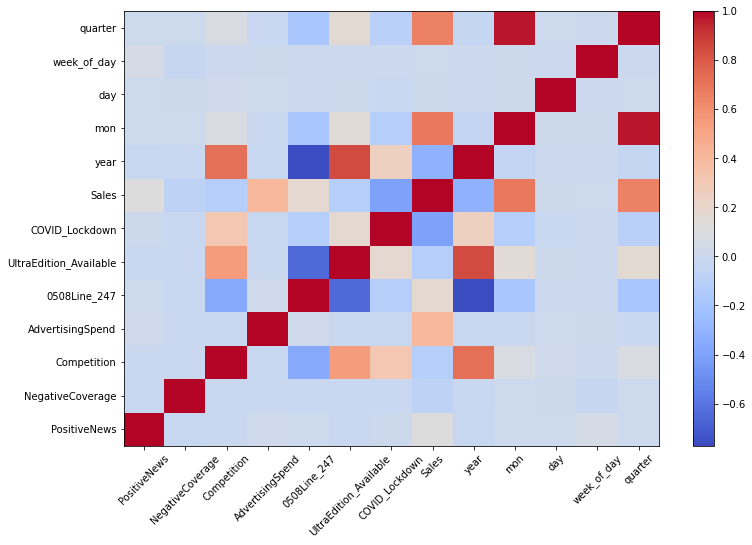

In [15]:
fig = plt.figure(figsize=(12, 8))
corr = MarketingSales.corr()
c = plt.pcolor(corr,cmap='coolwarm')
plt.yticks(np.arange(0.5, len(corr.index), 1), corr.index)
plt.xticks(np.arange(0.5, len(corr.columns), 1), corr.columns)
plt.xticks(rotation=45)
fig.colorbar(c)

**Findings**:

- Advertising has week positive correlation with sales
- Ultra Edition has week negative correlation with sales

---

Line plot for vac sales and advertising spend

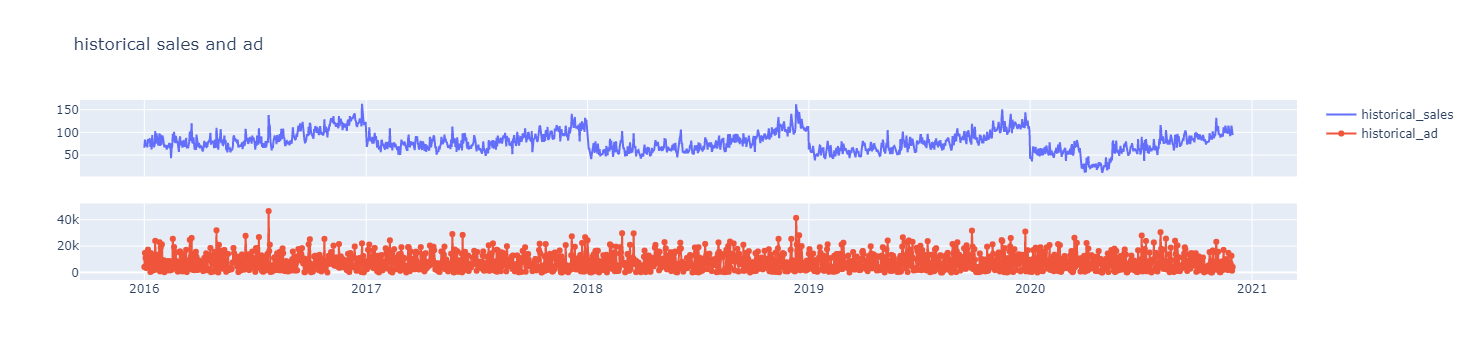

In [16]:

fig = make_subplots(rows=2, cols=1,shared_xaxes=True,)
fig.add_trace(go.Scatter(x=MarketingSales['Date'], y=MarketingSales['Sales'],
                    mode='lines',
                    name='historical_sales'),row=1,col=1)
fig.add_trace(go.Scatter(x=MarketingSales['Date'], y=MarketingSales['AdvertisingSpend'],
                    mode='lines+markers',
                    name='historical_ad'),row=2,col=1)
fig.update_layout( title_text="historical sales and ad")
fig.show()



**Findings**:

- It seems Vac sales share some similar trends with advertising spending. 

In [17]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(MarketingSales.Sales.dropna())
print('p-value: %f' % result[1])

p-value: 0.004538


**Conclusion**:

data can be assumed to be stationary hence we can proceed with the data without any transformation

### trend

Understanding the linear trend of vac sales 

In [18]:
sales = MarketingSales.copy()
sales.set_index('Date',inplace=True)
sales.head()

PositiveNews  NegativeCoverage  Competition  AdvertisingSpend  \
Date                                                                        
2016-01-01             0                 0            0           4199.86   
2016-01-02             0                 0            0          14768.20   
2016-01-03             0                 0            0          11019.79   
2016-01-04             0                 0            0           3358.30   
2016-01-05             0                 0            0           5207.19   

              Month       Day  0508Line_247  UltraEdition_Available  \
Date                                                                  
2016-01-01  January    Friday             1                       0   
2016-01-02  January  Saturday             1                       0   
2016-01-03  January    Sunday             1                       0   
2016-01-04  January    Monday             1                       0   
2016-01-05  January   Tuesday             1                       0   

            COVID_Lockdown  Sales  year  mon  day  week_of_day  quarter  
Date                                                                     
2016-01-01               0     66  2016    1    1            4        1  
2016-01-02               0     84  2016    1    2            5        1  
2016-01-03               0     78  2016    1    3            6        1  
2016-01-04               0     70  2016    1    4            0        1  
2016-01-05               0     73  2016    1    5            1        1

In [19]:
sales_df = sales['Sales'].copy()

In [20]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=sales_df.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

const  trend
Date                    
2016-01-01    1.0    1.0
2016-01-02    1.0    2.0
2016-01-03    1.0    3.0
2016-01-04    1.0    4.0
2016-01-05    1.0    5.0

In [21]:
from sklearn.linear_model import LinearRegression
# DeterministicProcess. Using this function will help us avoid some tricky failure cases that can arise with time series and linear regression. 
y = sales.Sales # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

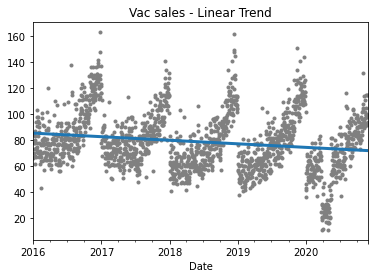

In [22]:
ax = sales['Sales'].plot(style=".", color="0.5", title="Vac sales - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

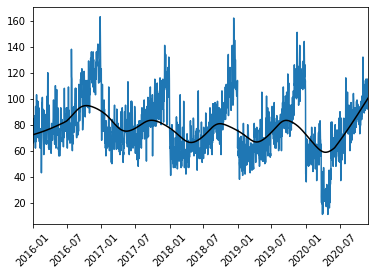

In [23]:
# LOESS
import statsmodels.api as sm
import pylab

smoothed = sm.nonparametric.lowess(exog=MarketingSales['Date'], endog=MarketingSales['Sales'], frac=0.2)

# Plot the fit line
fig, ax = pylab.subplots()

ax.plot(MarketingSales['Date'], MarketingSales['Sales'])
ax.plot(MarketingSales['Date'], smoothed[:, 1], c="k")
pylab.autoscale(enable=True, axis="x", tight=True)
plt.xticks(rotation=45);

**Findings**

Vac sales have an overall trend of decreasing over time, reached a historical low point during the covid period and have a strong bounce-back afterwards

### seasonality

In [24]:
# Helper function
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


C:\Users\Polaris\AppData\Local\Temp\ipykernel_27240\2272695042.py:5: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



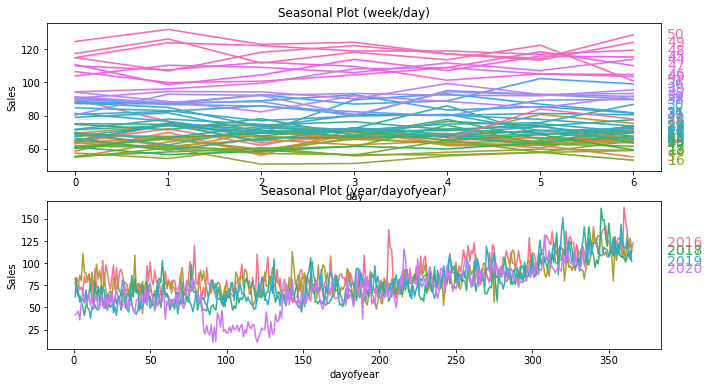

In [25]:
X = pd.DataFrame(sales_df)

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="Sales", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="Sales", period="year", freq="dayofyear", ax=ax1);

C:\Users\Polaris\AppData\Local\Temp\ipykernel_27240\2002938693.py:1: FutureWarning:

Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.



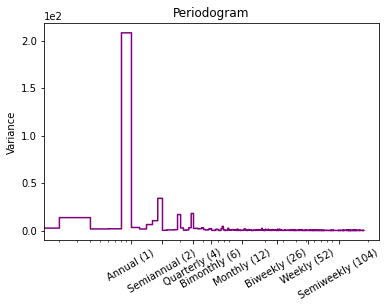

In [26]:
plot_periodogram(sales.Sales);

**Findings**

We couldn't observe a clear weekly/monthly pattern but found strong the annual season.

### vac sales vs ad spends

#### Aggregate vac sales data to
- month - year level
- day of week - month level

In [27]:
mhy = MarketingSales.groupby(['year','Month'])['Sales'].sum().reset_index()
mhy = pd.pivot(mhy,'year','Month','Sales')
year_col = [i for i in range(2016,2021)]
mhy = mhy.reindex(year_col)
# sns.heatmap(data=mhy[mon_row],cmap='RdYlBu_r')
# plt.title('vac sales by year and month - heatmap');

In [28]:
mh = MarketingSales.groupby(['Month','Day'])['Sales'].sum().reset_index()
mh = pd.pivot(mh,'Month','Day','Sales')
mon_row = ['January','February','March','April','May','June','July','August','September','October','November','December']
day_col = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
mh = mh.reindex(mon_row)
# sns.heatmap(data=mh[day_col],cmap='RdYlBu_r')
# plt.title('vac sales by month and week - heatmap');

#### All time advertising data (2016-2020)

Aggregate to
- year - month level
- day of week - month level

In [29]:
# combining all time advertising data
ad_all_time = pd.concat([MarketingSales[['Date', 'AdvertisingSpend', 'Month', 'Day']],DecemberAdData])
ad_all_time['year'] = ad_all_time['Date'].dt.year
ad_all_time.tail()

Date  AdvertisingSpend     Month        Day  year
26 2020-12-27            964.54  December     Sunday  2020
27 2020-12-28            578.13  December     Monday  2020
28 2020-12-29          29203.62  December    Tuesday  2020
29 2020-12-30          12686.89  December  Wednesday  2020
30 2020-12-31           9415.00  December   Thursday  2020

In [30]:
ahy = ad_all_time.groupby(['year','Month'])['AdvertisingSpend'].sum().reset_index()
ahy = pd.pivot(ahy,'year','Month','AdvertisingSpend')
ahy = ahy.reindex(year_col)
# sns.heatmap(data=ahy[mon_row],cmap='RdYlBu_r')
# plt.title('advertising spends by month and week - 2016-01 - 2020-12');

In [31]:
ah = ad_all_time.groupby(['Month','Day'])['AdvertisingSpend'].sum().reset_index()
ah = pd.pivot(ah,'Month','Day','AdvertisingSpend')
ah = ah.reindex(mon_row)
# sns.heatmap(data=ah[day_col],cmap='RdYlBu_r')
# plt.title('advertising spends by month and week - 2016-01 - 2020-12');

#### Heat map

Text(0.5, 1.0, 'ad spends')

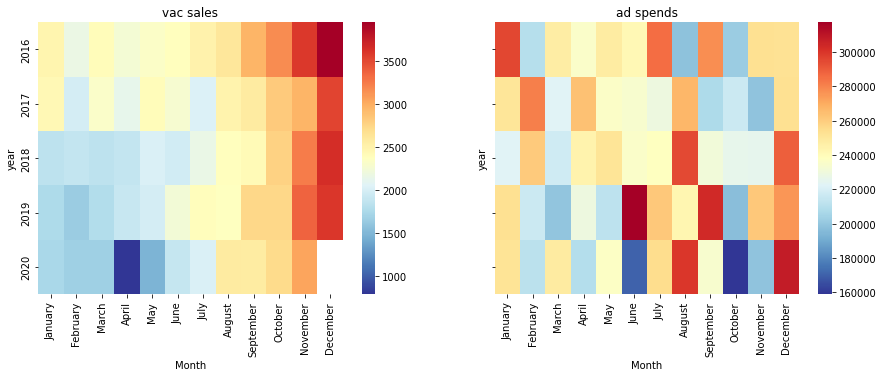

In [32]:
fig, axes = plt.subplots(1, 2,figsize=(15, 5),sharey=True)
fig.suptitle('')


sns.heatmap(data=mhy[mon_row],cmap='RdYlBu_r',ax=axes[0])
axes[0].set_title('vac sales')

sns.heatmap(data=ahy[mon_row],cmap='RdYlBu_r',ax=axes[1])
axes[1].set_title('ad spends')



**Findings**

Vac sales and ad spending have quite different patterns at the month-year level. Align with the conclusion of seasonality, we can observe a yearly pattern.

Vac sales

- Vac sales were not as popular as they used to be over the years
- Nov and Dec are months that have the most vac sales
- Jan - Jul don't have too many vacs sold

Ad spends
- Ads spend less in October.

Text(0.5, 1.0, 'ad spends')

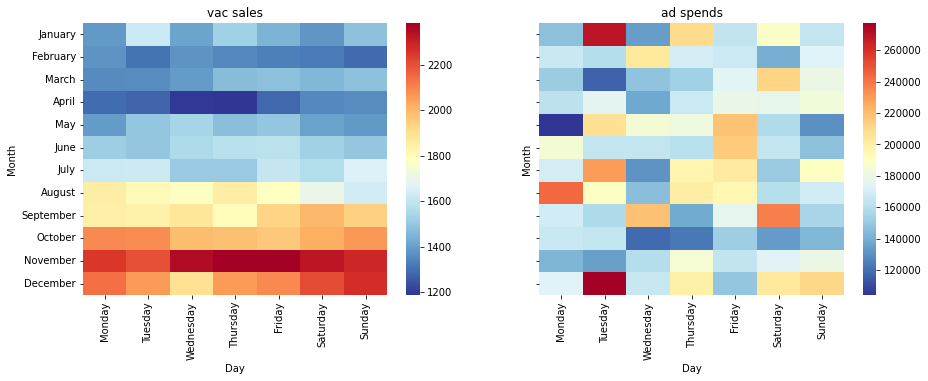

In [33]:
fig, axes = plt.subplots(1, 2,figsize=(15, 5),sharey=True)

sns.heatmap(data=mh[day_col],cmap='RdYlBu_r',ax=axes[0])
axes[0].set_title('vac sales')

sns.heatmap(data=ah[day_col],cmap='RdYlBu_r',ax=axes[1])
axes[1].set_title('ad spends')


**Findings**

No clear weekly pattern was observed for either vac sales or ad spending.

## Explanatory Variables

### covid

In [34]:
c = MarketingSales.COVID_Lockdown.value_counts().reset_index()
c.columns = ['COVID_Lockdown','days']
c['percentage'] = round(c['days']/c['days'].sum()*100,1)
c

COVID_Lockdown  days  percentage
0               0  1744        97.1
1               1    52         2.9

Text(0.5, 1.0, 'covid data percentage')

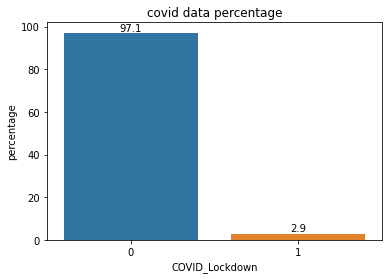

In [35]:
f = sns.barplot(x=c['COVID_Lockdown'],y=c['percentage'])
f.bar_label(f.containers[0])
plt.title('covid data percentage')

**Findings**

Covid data only takes about 3% of data, which can be removed/replaced in modelling

### Positive news

In [36]:
MarketingSales.PositiveNews.value_counts()/len(MarketingSales)

0    0.967706
1    0.032294
Name: PositiveNews, dtype: float64

### Negative coverage

In [37]:
MarketingSales.NegativeCoverage.value_counts()/len(MarketingSales)

0    0.991091
1    0.008909
Name: NegativeCoverage, dtype: float64

**Findings**

Positive news and negative coverage are very sparse in all time

### competition

In [38]:
MarketingSales.Competition.value_counts()/len(MarketingSales)

0    0.773385
1    0.226615
Name: Competition, dtype: float64

(<Figure size 1008x720 with 5 Axes>,
 array([<AxesSubplot:ylabel='2016'>, <AxesSubplot:ylabel='2017'>,
        <AxesSubplot:ylabel='2018'>, <AxesSubplot:ylabel='2019'>,
        <AxesSubplot:ylabel='2020'>], dtype=object))

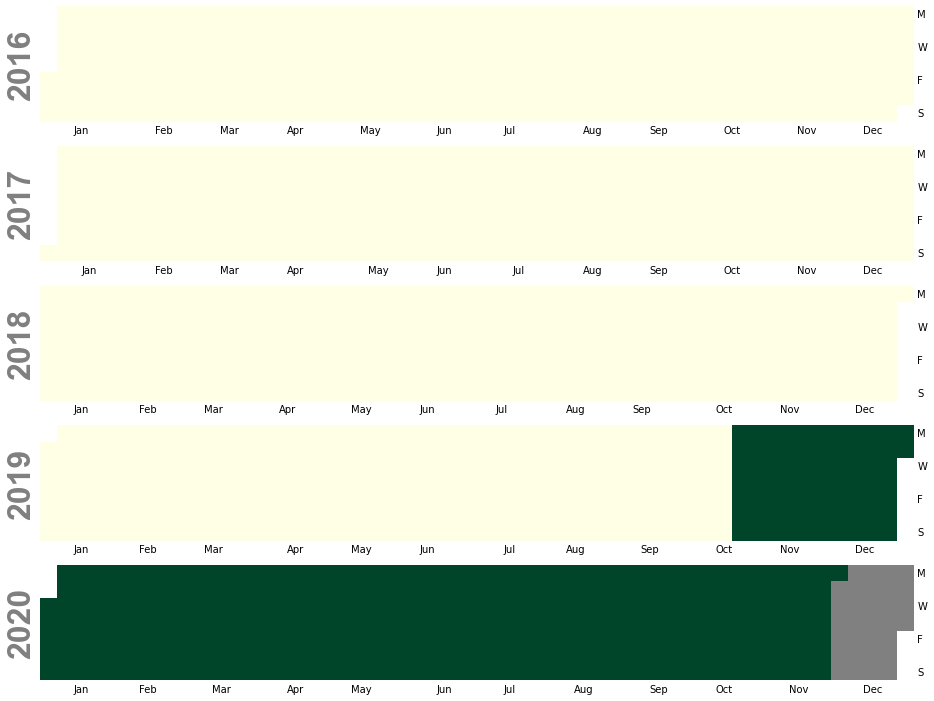

In [39]:
import calmap

competition = MarketingSales[['Date','Competition']].copy()
competition = competition.set_index('Date')
calmap.calendarplot(competition.Competition, monthticks=3, daylabels='MTWTFSS',
                    dayticks=[0, 2, 4, 6], cmap='YlGn',
                    fillcolor='grey', linewidth=0,
                    fig_kws=dict(figsize=(14, 10)))

**Findings**

Competition available form Oct 2019 till 2020 Nov

### 0508line

In [40]:
MarketingSales['0508Line_247'].value_counts()/len(MarketingSales)

0    0.695434
1    0.304566
Name: 0508Line_247, dtype: float64

(<Figure size 1008x720 with 5 Axes>,
 array([<AxesSubplot:ylabel='2016'>, <AxesSubplot:ylabel='2017'>,
        <AxesSubplot:ylabel='2018'>, <AxesSubplot:ylabel='2019'>,
        <AxesSubplot:ylabel='2020'>], dtype=object))

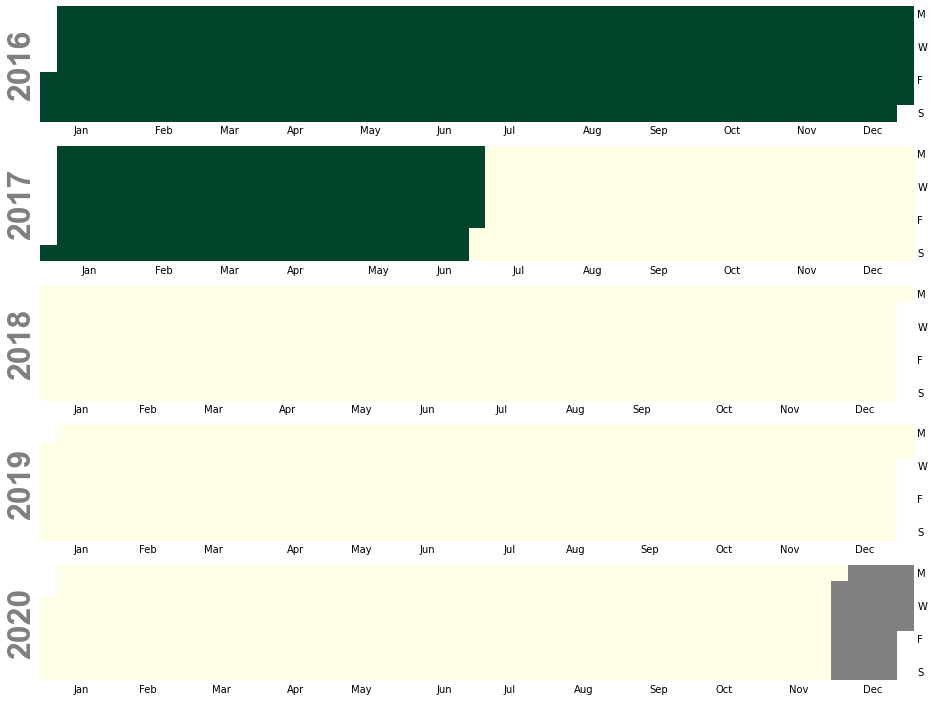

In [41]:
line = MarketingSales[['Date','0508Line_247']].copy()
line = line.set_index('Date')
calmap.calendarplot(line['0508Line_247'], monthticks=3, daylabels='MTWTFSS',
                    dayticks=[0, 2, 4, 6], cmap='YlGn',
                    fillcolor='grey', linewidth=0,
                    fig_kws=dict(figsize=(14, 10)))

**Findings**

The line calls for selling were only available from Jan 2016 to Jun 2017

### ultra edition

In [42]:
MarketingSales.UltraEdition_Available.value_counts()/len(MarketingSales)

0    0.507238
1    0.492762
Name: UltraEdition_Available, dtype: float64

(<Figure size 1008x720 with 5 Axes>,
 array([<AxesSubplot:ylabel='2016'>, <AxesSubplot:ylabel='2017'>,
        <AxesSubplot:ylabel='2018'>, <AxesSubplot:ylabel='2019'>,
        <AxesSubplot:ylabel='2020'>], dtype=object))

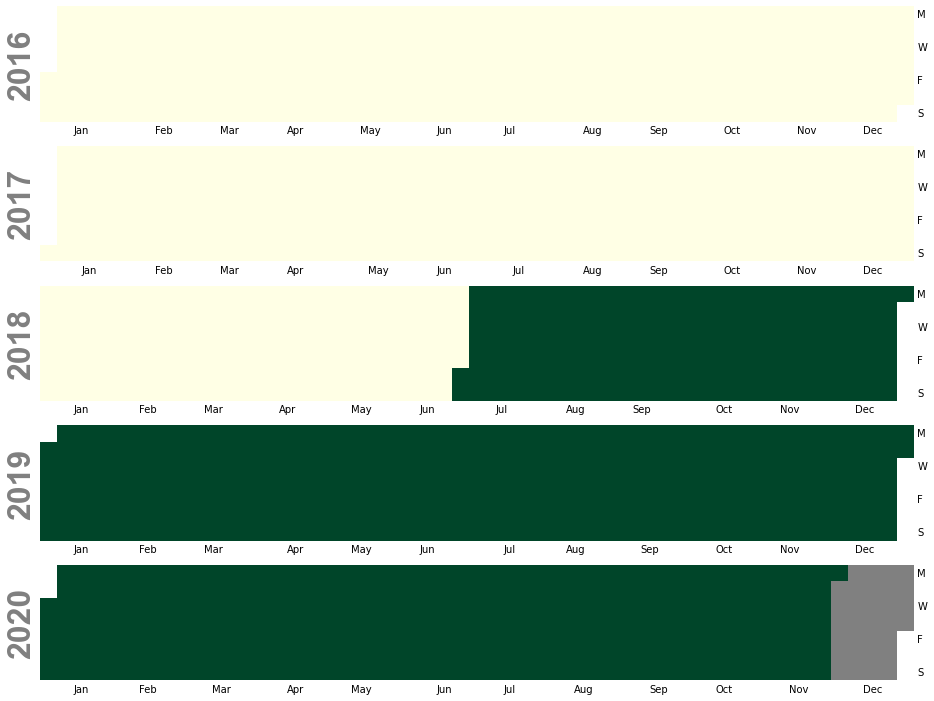

In [43]:
ultra = MarketingSales[['Date','UltraEdition_Available']].copy()
ultra = ultra.set_index('Date')
calmap.calendarplot(ultra['UltraEdition_Available'], monthticks=3, daylabels='MTWTFSS',
                    dayticks=[0, 2, 4, 6], cmap='YlGn',
                    fillcolor='grey', linewidth=0,
                    fig_kws=dict(figsize=(14, 10)))

**Findings**

The ultra edition has been available since Jun 2018 

### Box plot

To understand sales difference under different factors

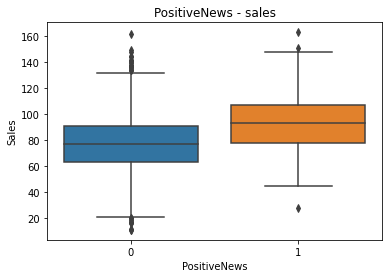

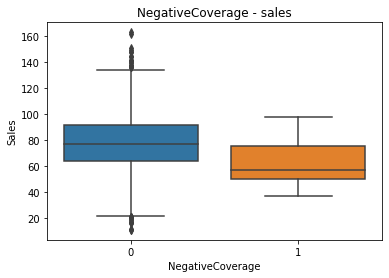

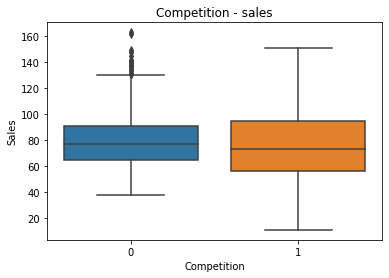

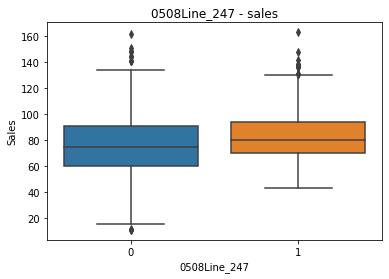

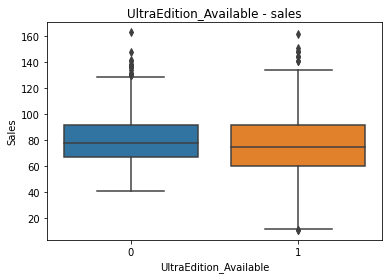

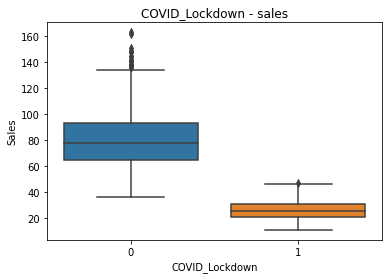

In [44]:
feature_bin = ['PositiveNews', 'NegativeCoverage', 'Competition',  '0508Line_247','UltraEdition_Available', 'COVID_Lockdown']
for f in feature_bin:
    figure = plt.figure()
    sns.boxplot(data=MarketingSales,x=f,y='Sales')
    plt.title(f'{f} - sales')

**Findings**:
- Positive news has a higher sales, while negative news has a slightly lower sales
- Covid has a significant impact on sales. Sales are much less than usual
- Sales difference for competition, 0508line and ultra edition is not very clear


# Forecasting

## Multistep Forecasting - Direct strategy (optional)

In [45]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

In [46]:
# df = pd.concat([MarketingSales,DecemberAdData]).fillna(0)
df = MarketingSales.copy()
df['mon'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['week_of_day'] = df['Date'].dt.weekday
df['quarter'] = df['Date'].dt.quarter
df.set_index('Date',inplace=True)
df.tail()

PositiveNews  NegativeCoverage  Competition  AdvertisingSpend  \
Date                                                                        
2020-11-26             0                 0            1           2238.03   
2020-11-27             0                 0            1           6378.24   
2020-11-28             1                 0            1          12670.48   
2020-11-29             0                 0            1           1317.66   
2020-11-30             0                 0            1           4144.00   

               Month       Day  0508Line_247  UltraEdition_Available  \
Date                                                                   
2020-11-26  November  Thursday             0                       1   
2020-11-27  November    Friday             0                       1   
2020-11-28  November  Saturday             0                       1   
2020-11-29  November    Sunday             0                       1   
2020-11-30  November    Monday             0                       1   

            COVID_Lockdown  Sales  year  mon  day  week_of_day  quarter  
Date                                                                     
2020-11-26               0     92  2020   11   26            3        4  
2020-11-27               0     99  2020   11   27            4        4  
2020-11-28               0    115  2020   11   28            5        4  
2020-11-29               0     98  2020   11   29            6        4  
2020-11-30               0     94  2020   11   30            0        4

In [47]:
# create lag feature
for i in range(1,8):
    tmp = f'lag_{i}'
    df[tmp] = df.Sales.shift(i)
df.fillna(0,inplace=True)

In [48]:
features = ['PositiveNews', 'NegativeCoverage', 'Competition',
       'AdvertisingSpend', '0508Line_247',
       'UltraEdition_Available', 'COVID_Lockdown', 'Sales', 'year', 'mon',
       'day', 'week_of_day', 'quarter','lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       'lag_6', 'lag_7']

In [49]:
X = df[features].copy()
y=df.Sales.copy()

In [50]:
# y = flu_trends.FluVisits.copy()
# X = make_lags(y, lags=4).fillna(0.0)


def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)


# Eight-week forecast
y = make_multistep_target(y, steps=31).dropna()

# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
y, X = y.align(X, join='inner', axis=0)

In [51]:
split_index_t = X[(X['year']==2020)&(X['mon']==9)&(X['day']==30)].index.values[0]
split_index_v = X[(X['year']==2020)&(X['mon']==10)&(X['day']==31)].index.values[0]

In [52]:
X_train = X.loc[X.index<=split_index_t].copy()
X_test = X.loc[(X.index>split_index_t)&(X.index<=split_index_v)].copy()
y_train = y.loc[y.index<=split_index_t].copy()
y_test = y.loc[(y.index>split_index_t)].copy()

In [53]:
# # Create splits
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

In [54]:
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

In [55]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))



Train RMSE: 1.45
Test RMSE: 12.54


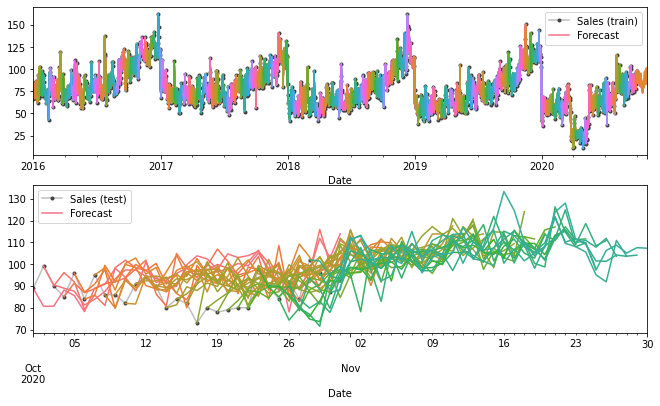

In [56]:
palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = df.Sales[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['Sales (train)', 'Forecast'])
ax2 = df.Sales[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['Sales (test)', 'Forecast'])


The model is overfit

In [57]:
a = y_pred.iloc[-1].reset_index()
a.columns = ['step','sales']

In [58]:
b = MarketingSales[MarketingSales['Date']>'2020-10-31']['Sales'].copy().reset_index()

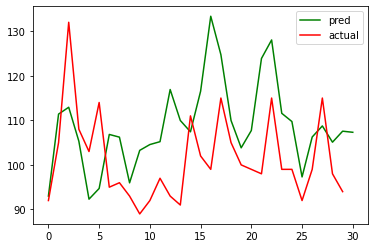

In [59]:
plt.plot(a.index, a.sales, 'g', label='pred')
plt.plot(b.index, b.Sales, 'r', label='actual')

plt.legend()
plt.show()

## Ensemble model

### Prophet - vac sales forecasting

In [60]:
from prophet import Prophet

In [61]:
pdf = MarketingSales[['Date','Sales']].copy()
pdf.columns = ['ds','y']

In [62]:
m = Prophet(yearly_seasonality=True)
m.fit(pdf)
future = m.make_future_dataframe(periods=31)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
D:\tools\anaconda\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

D:\tools\anaconda\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

D:\tools\anaconda\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



ds       yhat  yhat_lower  yhat_upper
1822 2020-12-27  93.384037   76.566855  109.565737
1823 2020-12-28  89.290291   72.948391  106.105091
1824 2020-12-29  86.729014   69.095110  102.451552
1825 2020-12-30  82.190133   66.712489   98.786761
1826 2020-12-31  80.118674   63.833708   96.614479

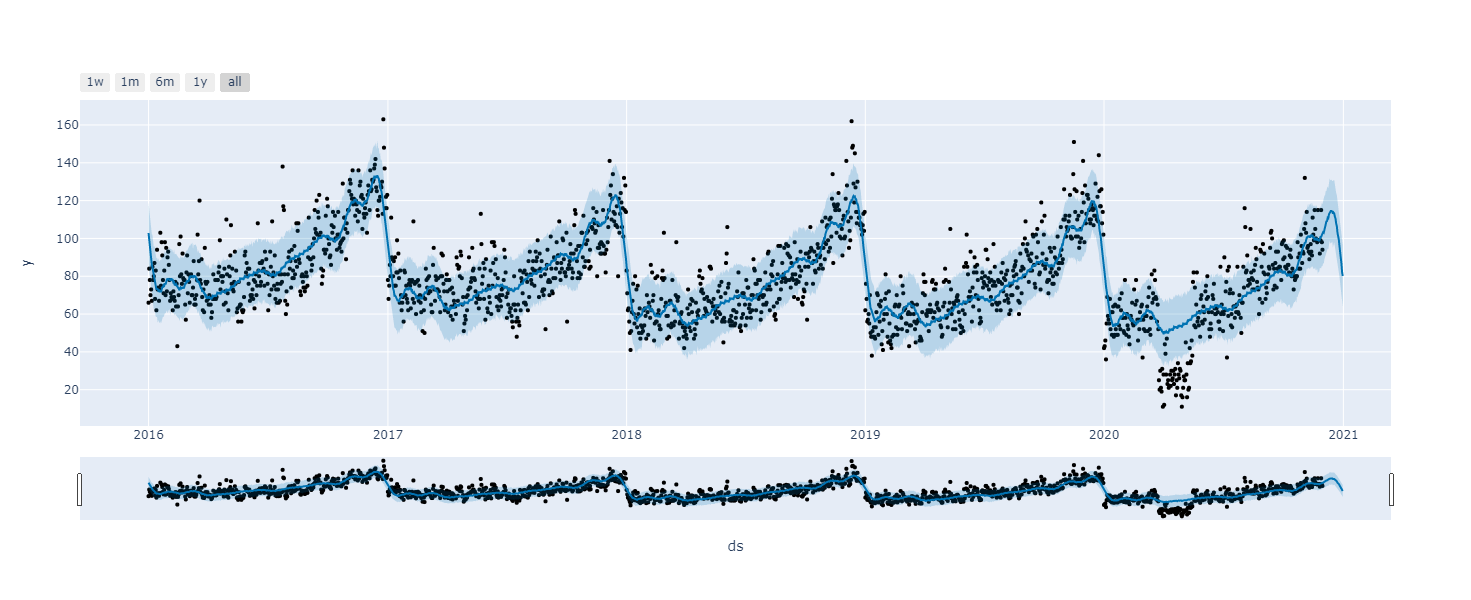

In [63]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

D:\tools\anaconda\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

D:\tools\anaconda\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



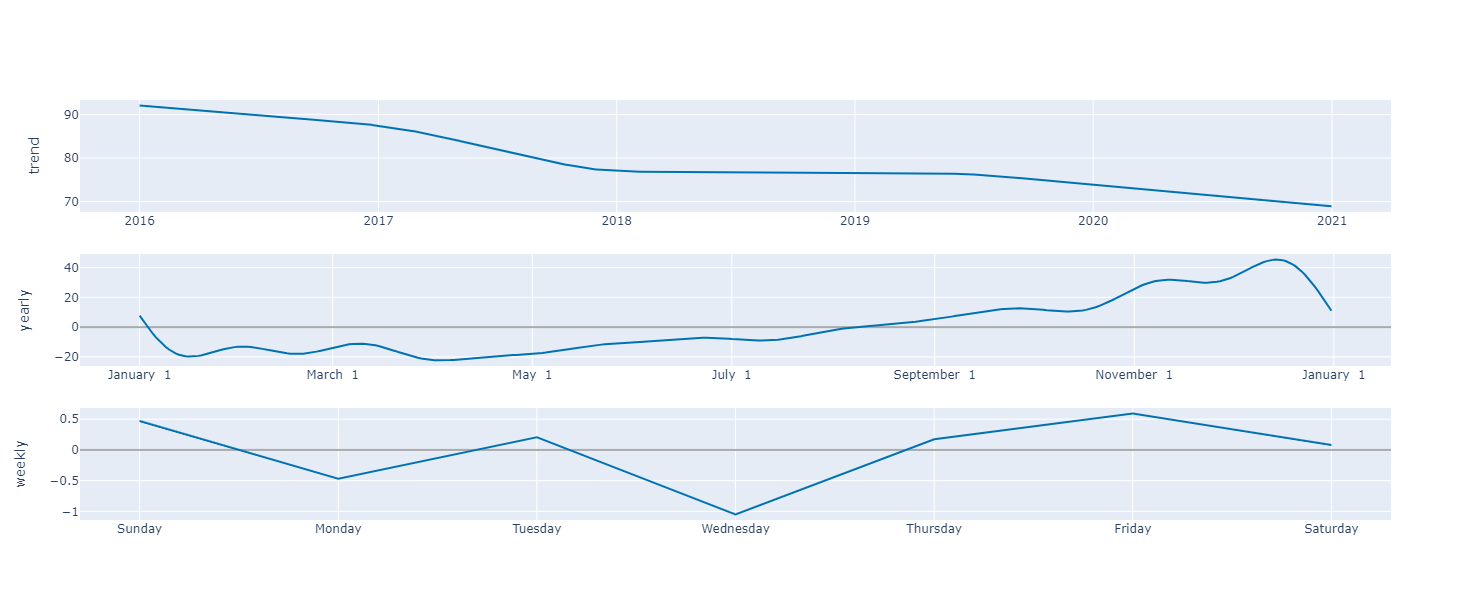

In [64]:
plot_components_plotly(m, forecast)

**Findings**

- The overall trend predicts decreasing in demand for vacs
- More sales in Nov and Dec
- More sales on Friday and Sunday

In [65]:
# Predition for Dec 2020
prophet_dec_pred = int(forecast[forecast.ds>='2020-12-01']['yhat'].sum())
prophet_dec_pred

3257

In [66]:
# create dataframe with historical sales data, Prophet prediction and residuals (DEC 2020 not included)
sales_residual = pd.merge(MarketingSales,forecast[['ds','yhat']],left_on='Date',right_on='ds',how='left')
sales_residual['residual'] = sales_residual.Sales - sales_residual.yhat
sales_residual.head()

Date  PositiveNews  NegativeCoverage  Competition  AdvertisingSpend  \
0 2016-01-01             0                 0            0           4199.86   
1 2016-01-02             0                 0            0          14768.20   
2 2016-01-03             0                 0            0          11019.79   
3 2016-01-04             0                 0            0           3358.30   
4 2016-01-05             0                 0            0           5207.19   

     Month       Day  0508Line_247  UltraEdition_Available  COVID_Lockdown  \
0  January    Friday             1                       0               0   
1  January  Saturday             1                       0               0   
2  January    Sunday             1                       0               0   
3  January    Monday             1                       0               0   
4  January   Tuesday             1                       0               0   

   Sales  year  mon  day  week_of_day  quarter         ds        yhat  \
0     66  2016    1    1            4        1 2016-01-01  102.864797   
1     84  2016    1    2            5        1 2016-01-02   99.099069   
2     78  2016    1    3            6        1 2016-01-03   96.309878   
3     70  2016    1    4            0        1 2016-01-04   92.294852   
4     73  2016    1    5            1        1 2016-01-05   90.035863   

    residual  
0 -36.864797  
1 -15.099069  
2 -18.309878  
3 -22.294852  
4 -17.035863

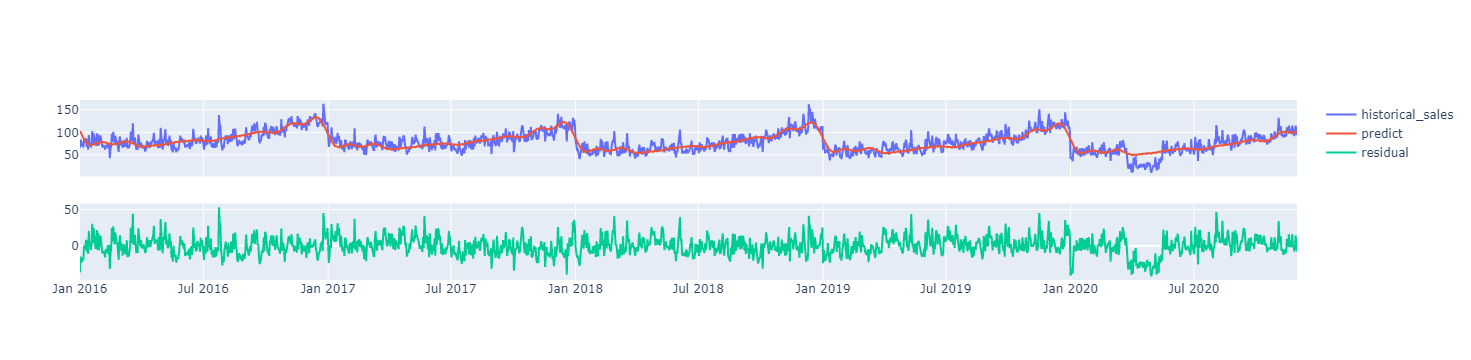

In [67]:
# Visualization for historical sales, Prophet prediction and residuals
fig = make_subplots(rows=2, cols=1,shared_xaxes=True,)
fig.add_trace(go.Scatter(x=sales_residual['Date'], y=sales_residual['Sales'],
                    mode='lines',
                    name='historical_sales'),row=1,col=1)
fig.add_trace(go.Scatter(x=sales_residual['Date'], y=sales_residual['yhat'],
                    mode='lines',
                    name='predict'),row=1,col=1)
fig.add_trace(go.Scatter(x=sales_residual['Date'], y=sales_residual['residual'],
                    mode='lines',
                    name='residual'),row=2,col=1)
#fig.update_layout( title_text="historical sales and ad")
fig.show()

<AxesSubplot:xlabel='residual', ylabel='Count'>

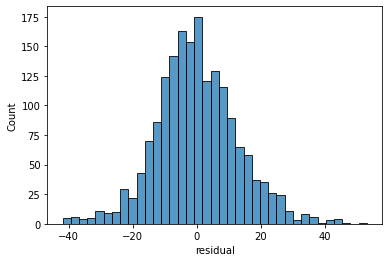

In [68]:
sns.histplot(sales_residual.residual)

### Random forest - residual prediction

In [69]:
features_col = ['PositiveNews', 'NegativeCoverage', 'Competition',
       'AdvertisingSpend',  '0508Line_247',
       'UltraEdition_Available', 'COVID_Lockdown']

In [70]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

Y = sales_residual.residual.copy()
X = sales_residual[features_col].copy()
# Split the data into train and test data:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2,random_state=42)
# Build the model with the random forest regression algorithm:
model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

In [71]:
print('RMSE - test set: ',mean_squared_error(Y_test,Y_pred,squared=False))

RMSE - test set:  8.1837017799065


In [72]:
print('RMSE - training set: ',mean_squared_error(Y_train,model.predict(X_train),squared=False))

RMSE - training set:  7.241859975994451


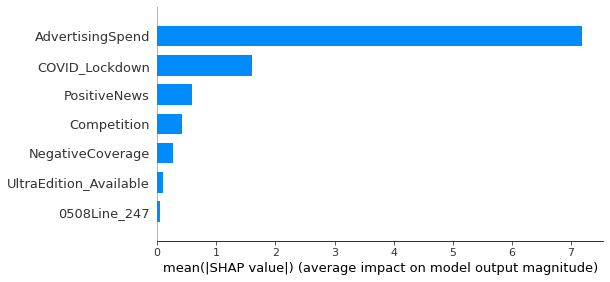

In [73]:
import shap
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

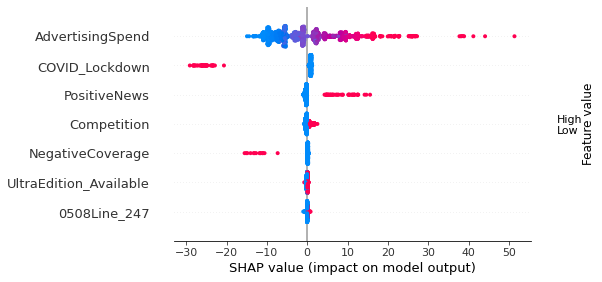

In [74]:
shap.summary_plot(shap_values, X_train)

**Findings**
- AdverstingSpend has the most impact on sales among all available features. Higher the ad spending could potentially contribute more to sales
- Competition has a slightly positive impact on sales
- Positive news has positive impacts while negative news has negative impacts on sales
- Ultra Edition and 0508 line don't affect sales too much

In [75]:
# contribution of differenct feature for row 3 as an example
def shap_plot(ind): 
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    p = shap.force_plot(explainer.expected_value, shap_values[ind], X_test.iloc[[ind]])
    # plt.savefig('temp.svg')
    # plt.close()
    return p

shap.initjs()
shap_plot(3)

In [76]:
shap.force_plot(shap.TreeExplainer(model).expected_value,shap.TreeExplainer(model).shap_values(X_test),X_test)

Choose Y axis as AdvertisingSpend effect could be more clear.

**Findings**
- Advertising Spend < 8000, it contribute negative to sales values
- Advertising spend would be more effective when higher than 8000. 

### Prediction for Dec 2020
Using Dec 2020 advertising data to predict residuals of Dec 2020

In [77]:
dec = DecemberAdData[['AdvertisingSpend']].copy()
for col in X_test.columns:
    if col!='AdvertisingSpend':
        dec[col] = 0

In [78]:
rf_dec_pred = model.predict(dec[X_train.columns])

In [79]:
# Prophet Dec 2020 forcasting
dec_forcast = forecast[forecast.ds>='2020-12-01'][['ds', 'yhat']].copy()
# ensemble = Prophet_sales_pred + rf_residual_pred
dec_forcast['sales_pred'] = (dec_forcast.yhat+model.predict(dec[X_train.columns]).transpose()).astype(int)

In [80]:
print('Sales in total predict for Dec 2020: ',dec_forcast.sales_pred.sum())

Sales in total predict for Dec 2020:  3346


We need to have at least 3346 Vac for Dec 2020 to ensure stock

In [81]:
# Sales goal
3900-3346

554

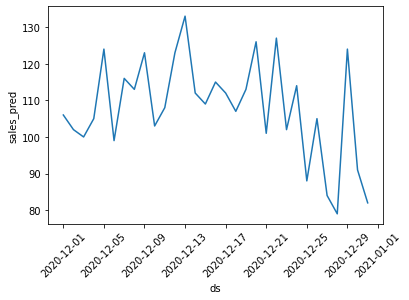

In [82]:
sns.lineplot(data=dec_forcast,x='ds',y='sales_pred')
plt.xticks(rotation=45);

**Recommendation**

To meet the sales goals at 3900, we need to sell 554 more vacs

- Based on the insights of SHAP, we could rearrange advertising spend that less than 8000 into bigger advertising. Or increasing the advertising spend.
- Adding promotion for vacs
- Adding more varieties to advertising media

Example:

If we replace the days that have ad spending less than 8000 to 20000, (We're expecting around 19 vac sales increase for an ad at $20000  based on sharp force plot)

In [83]:
print('We need $',int(554/19*20000-36265.63),'more for advertising on Dec')

We need $ 546892 more for advertising on Dec


In [84]:
DecemberAdData[DecemberAdData.AdvertisingSpend<=8000].sum()

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


AdvertisingSpend                                             36265.63
Month               DecemberDecemberDecemberDecemberDecemberDecemb...
Day                 ThursdaySundayThursdayFridayMondayTuesdayFrida...
dtype: object

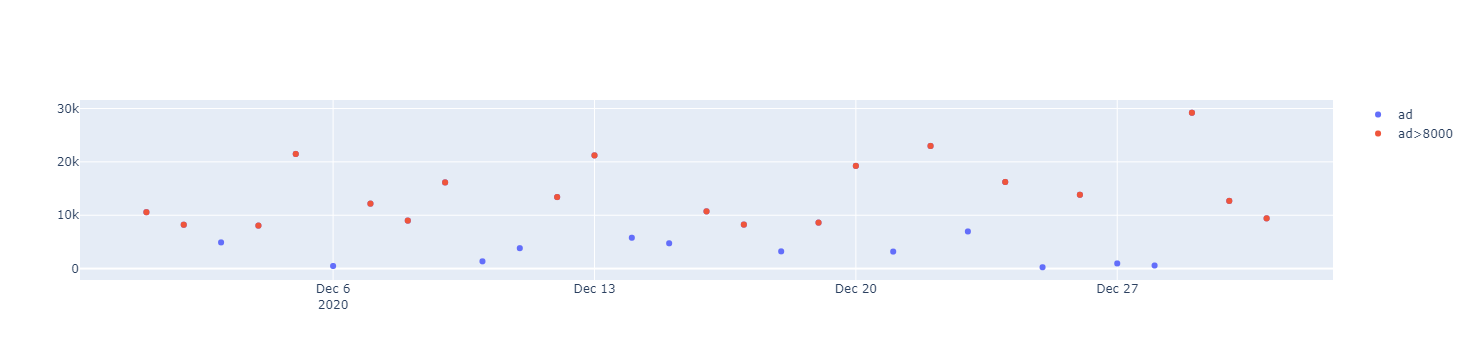

In [85]:
# Visualization for adversting spend on Dec 2020
fig = make_subplots(rows=1, cols=1,shared_xaxes=True,)
fig.add_trace(go.Scatter(x=DecemberAdData['Date'], y=DecemberAdData['AdvertisingSpend'],
                    mode='markers',
                    name='ad'),row=1,col=1)
fig.add_trace(go.Scatter(x=DecemberAdData[DecemberAdData.AdvertisingSpend>8000]['Date'], y=DecemberAdData[DecemberAdData.AdvertisingSpend>8000]['AdvertisingSpend'],
                    mode='markers',
                    name='ad>8000'),row=1,col=1)

fig.show()

In [86]:
print(f'There are {len(DecemberAdData[DecemberAdData.AdvertisingSpend<=8000])} days which advertising spending less than 8000')

There are 12 days which advertising spending less than 8000


## ElasticNet (optional)

<AxesSubplot:xlabel='residual', ylabel='AdvertisingSpend'>

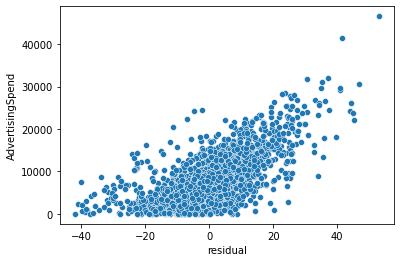

In [87]:
sns.scatterplot(data=sales_residual,x='residual',y='AdvertisingSpend')

**Findings**

Residual has a clear postive relationship with ad spends

In [88]:
from sklearn.linear_model import ElasticNet

Y = sales_residual[sales_residual.COVID_Lockdown==0].residual.copy()
X = sales_residual[sales_residual.COVID_Lockdown==0][features_col].copy()
# Split the data into train and test data:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2,random_state=42)

regr = ElasticNet(random_state=42)
regr.fit(X_train, Y_train)
Y_pred = regr.predict(X_test)
print(regr.coef_,'\n',regr.intercept_)


[ 0.         -0.          0.          0.00138682  0.          0.
  0.        ] 
 -10.039040913265111


In [89]:
X_train.columns

Index(['PositiveNews', 'NegativeCoverage', 'Competition', 'AdvertisingSpend',
       '0508Line_247', 'UltraEdition_Available', 'COVID_Lockdown'],
      dtype='object')

In [90]:
feature_importance = pd.DataFrame(index = X_train.columns, data = np.abs(regr.coef_))
feature_importance.columns = ['coef']

In [91]:
from sklearn.metrics import mean_squared_error,r2_score

In [92]:
np.sqrt(mean_squared_error(Y_train,regr.predict(X_train)))

8.106410482393349

In [93]:
np.sqrt(mean_squared_error(Y_test,Y_pred))

9.118831092050092

In [94]:
r2_score(Y_test,Y_pred)

0.5206061338824144

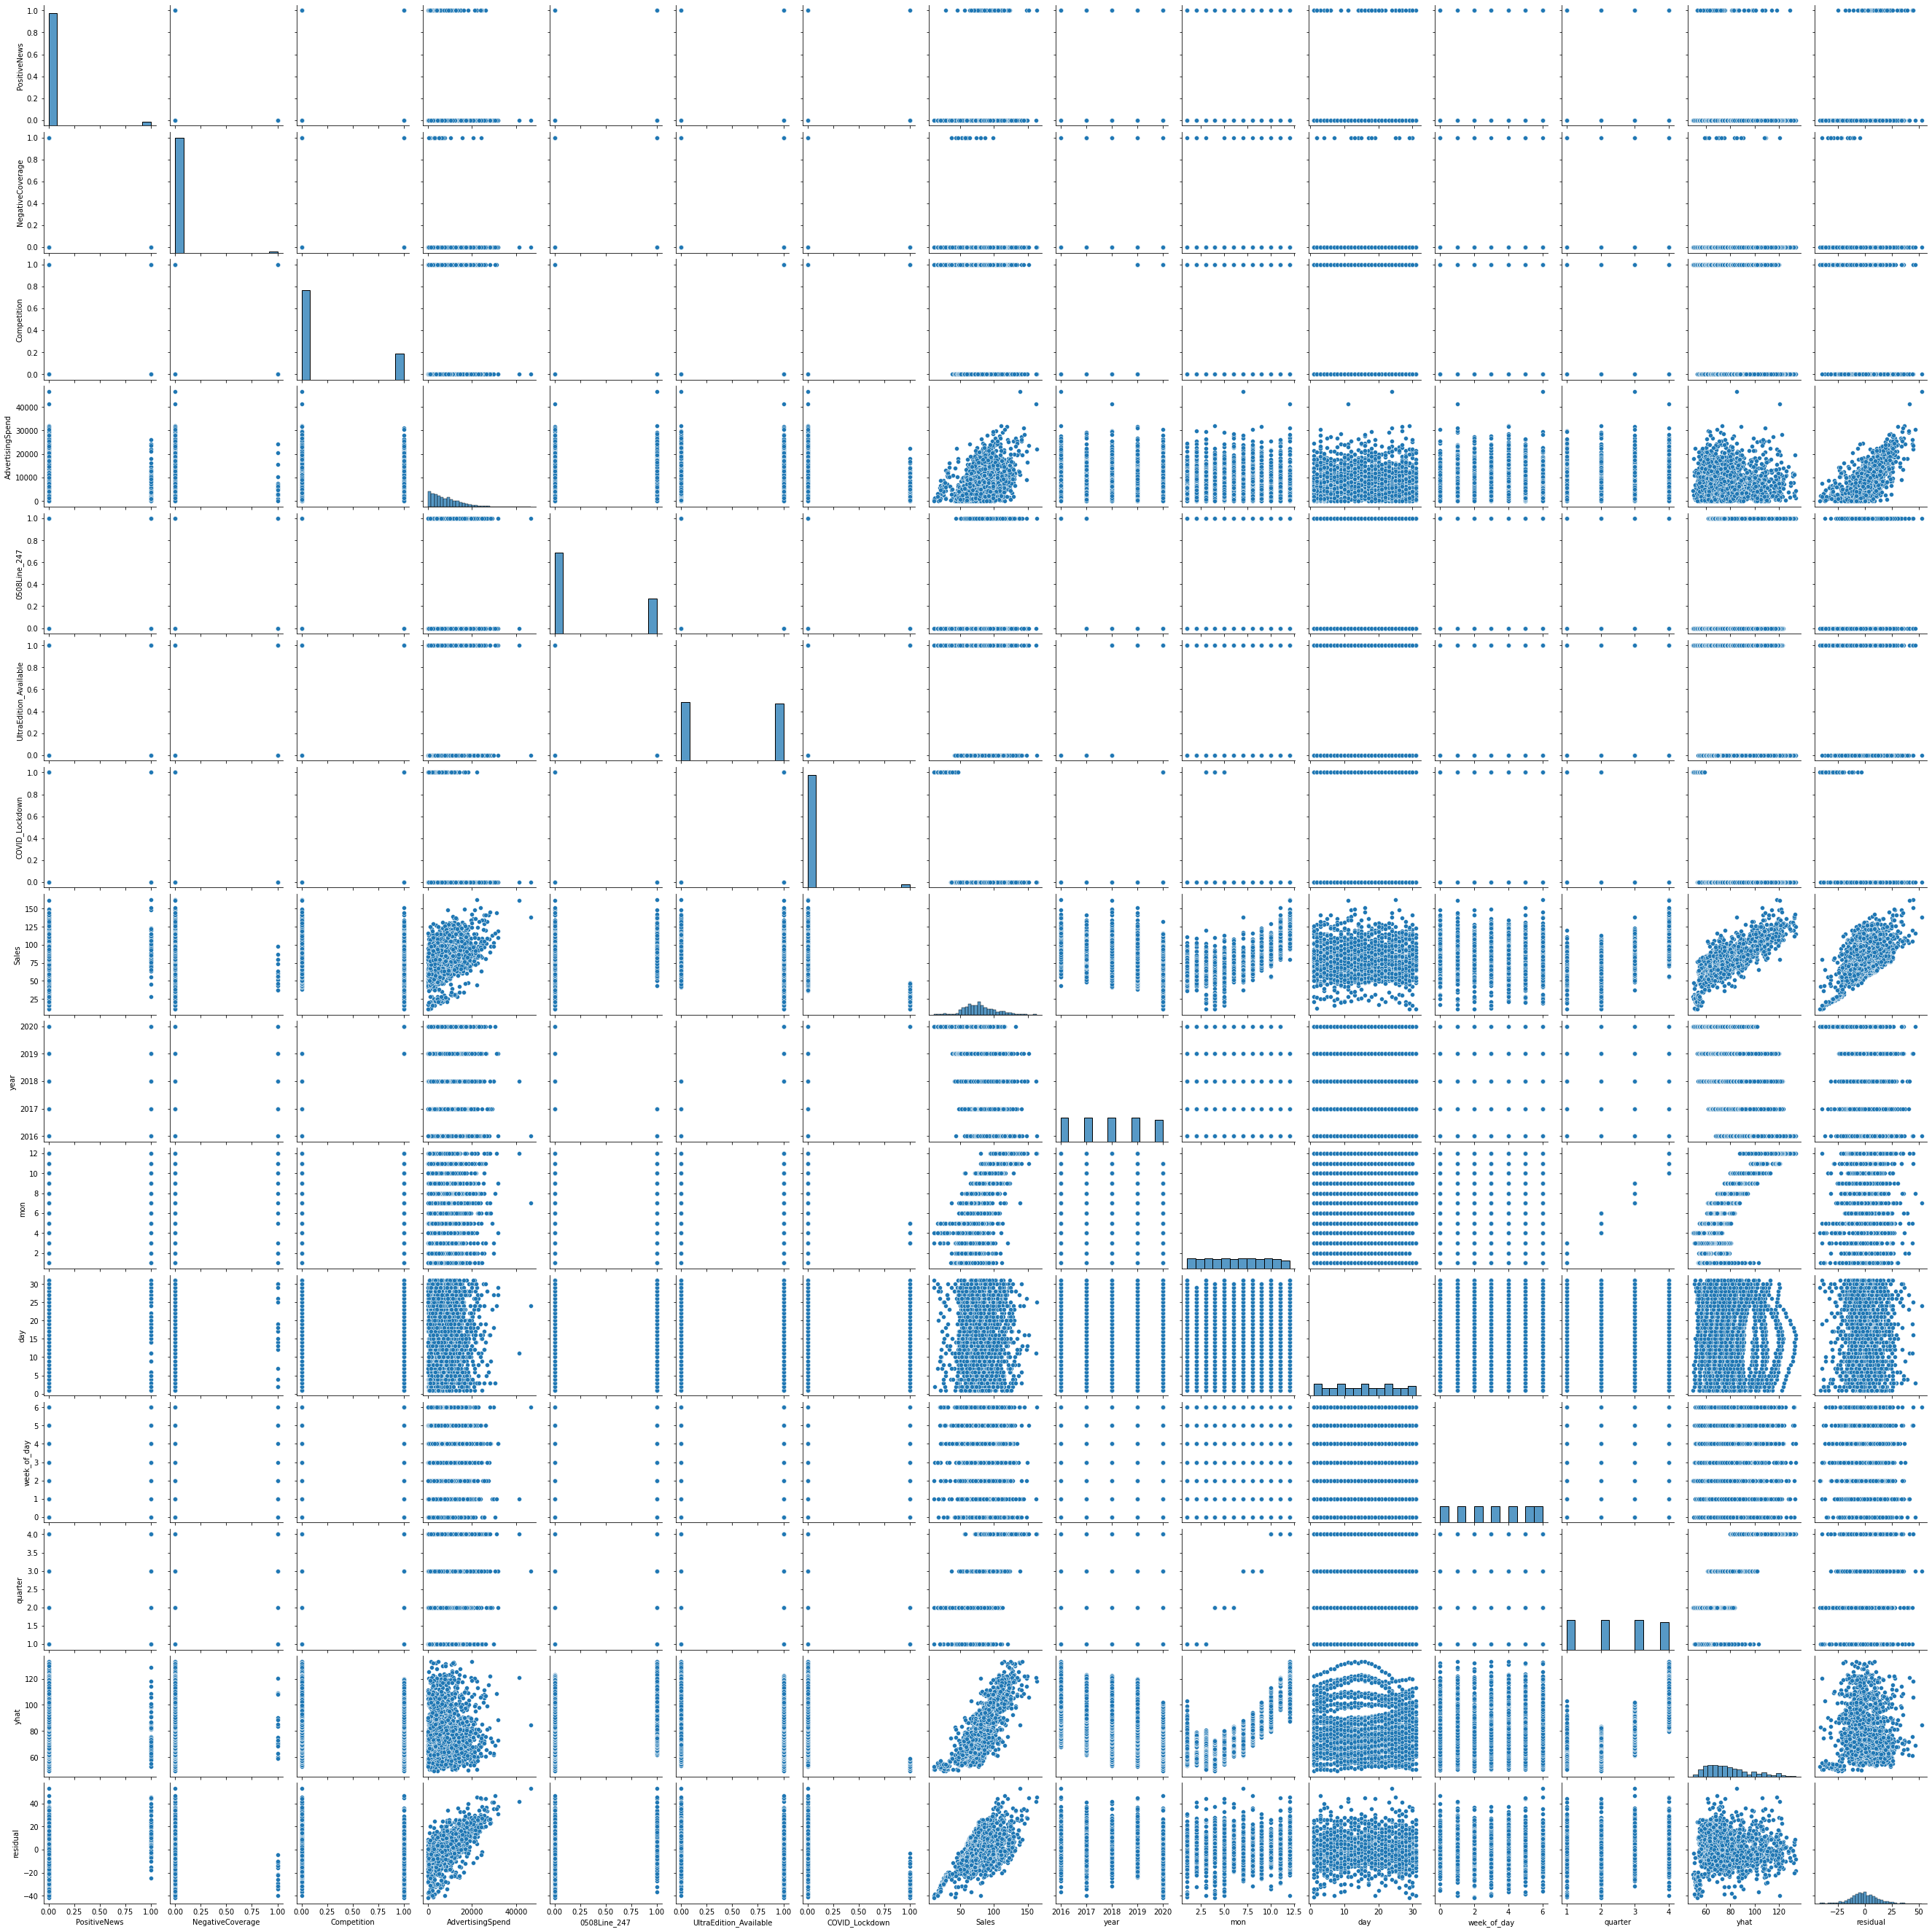

In [95]:
sns.pairplot(sales_residual)

# Requirements

In [96]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

matplotlib==3.5.2
plotly==5.6.0
numpy==1.21.5
xgboost==1.6.1
pandas==1.4.1
scikit-learn==1.0.2
prophet==1.0.1
shap==0.40.0
future==0.18.2
statsmodels==0.13.2
seaborn==0.11.2
calmap==0.0.9
